# Tracking with DeepSORT

Multiple-Object Tracking (MOT) is a task in which, given a video and a class of objects, one attempts to track individual objects through time. The objective is to detect the position of objects in a video and associate the same object across frames.

As the performance of deep learning object detectors has increased, MOT algorithms have become increasingly reliant on the accuracy of the detections. 

In this tutorial, we will show you how to use the two basic MOT algorithms, Simple Online Realtime Tracking (SORT) and  Simple Online Realtime Tracking with a Deep Association Metric (DeepSORT), and compare their performance.

DeepSORT is a simple MOT algorithm that uses deep learning to learn a metric for comparing the appearance of objects. It is based on the SORT algorithm, which uses a Kalman Filter to track objects and an Hungarian algorithm for data association.

* [Simple Online and Realtime Tracking](https://arxiv.org/abs/1602.00763)
* [Simple Online and Realtime Tracking with a Deep Association Metric](https://arxiv.org/abs/1703.07402)

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from soccertrack.detection_model.base import Detection
from soccertrack.tracking_model.tracker import MultiObjectTracker
from soccertrack.tracking_model.matching import EuclideanDistance


dt = 1/25
model_spec = {
    "dt": 1 / 25,
    "order_pos": 1,
    "dim_pos": 2,
    "order_size": 0,
    "dim_size": 2,
    "q_var_pos": 998.9,
    "r_var_pos": 0.0001,
    "q_var_size": 41.7,
    "r_var_size": 0.1,
    "p_cov_p0": 0.0012,
}

tracker_kwargs = {
    "max_staleness": 5,
    "smooth_feature_gamma": 0.5,
    "smooth_score_gamma": 0.5,
}

tracker = MultiObjectTracker(dt, model_spec=model_spec, tracker_kwargs=tracker_kwargs,matching_fn=EuclideanDistance(50))
for frame_idx in (pbar := tqdm(range(len(dets)))):
    
    # detect objects using the detection model
    detections = dets[frame_idx]
    detections = sorted(detections, key=lambda x:x.score, reverse=True)[:22]
    
    # update the state of the multi-object-tracker tracker
    # with the list of bounding boxes
    tracker.step(detections=detections)
    
    tracks = tracker.active_tracks()
    pbar.set_postfix({f"Number of tracks": len(tracks)})
    
bbdf_pred_ft = tracker.to_bbdf()
bbdf_pred_ft.sort_index(inplace=True)

print(mota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred_ft))

### Preparing the detection model 

Although the original paper uses the Faster Region CNN (FrRCNN) detection framework for object detection, we will use fine-tuned YOLOv5 models trained on the soccertrack drone dataset as it is faster and more accurate. The model checkpoints can be downloaded from [here](). Place them in the `models` folder and use the following code to load them.

YOLOv5 🚀 v6.2-239-gf33718f Python-3.9.14 torch-1.13.1 CPU

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 


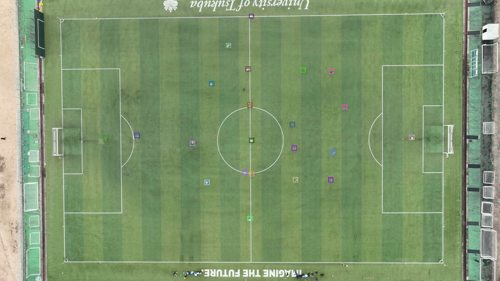

In [2]:
import soccertrack
from soccertrack import Camera, detection_model
from soccertrack.utils import get_git_root
from soccertrack.logger import show_df

root = get_git_root()
model_name = "yolov5"
model_repo = root / "external" / "yolov5"
model_ckpt = root / "models" / "yolov5" / "yolov5x_last.pt"
det_model = detection_model.load(model_name, model_repo, model_ckpt)

dataset_path = soccertrack.datasets.get_path("top-view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

bbdf = soccertrack.load_df(path_to_csv)  # We will use this as ground truth
cam = Camera(path_to_mp4)  # Camera object will be used to load frames
frame = cam.get_frame(0)[:, :, ::-1]  # Get first frame

det_model.model.conf = 0.01
det_model.model.size = 1920

det_result = det_model(frame, augment=True)

# take the top 22 detections
det_result.pred = det_result.pred[:22]

# Display the detections
show_df(det_result.to_df().head())

# Visualize the detections
im = det_result.show(width=5)
im.thumbnail((500, 500))
im

## Preparing the Appearance Model

In [4]:
from soccertrack.image_model import ImageEmbedder

dirpath = root / "models" / "resnet18"
ckpt_path = list(dirpath.glob('*.ckpt'))[-1]
image_model = ImageEmbedder.load_from_checkpoint(ckpt_path, num_classes=2)

### Preparing the Motion Model

Here we define the object model, i.e. the representation and the motion model used to propagate a target’s identity into the next frame. We use a Kalman filter to model the target’s motion.

In [7]:

dt = 1 / 25
model_spec = {
    "dt": 1 / 25,
    "order_pos": 1,
    "dim_pos": 2,
    "order_size": 0,
    "dim_size": 2,
    "q_var_pos": 998.9,
    "r_var_pos": 0.0001,
    "q_var_size": 41.7,
    "r_var_size": 0.1,
    "p_cov_p0": 0.0012,
}


### Tracking

ModuleNotFoundError: No module named 'soccetrack'

In [17]:
from soccertrack.logger import tqdm, set_log_level
from soccertrack.utils.draw import draw_tracks

set_log_level('INFO')
dets = []
for frame in (pbar := tqdm(cam.iter_frames())):
    
    # detect objects using the detection model
    detections = det_model(frame).to_list()
    dets.append(detections)
    
    # update the state of the multi-object-tracker tracker
    # with the list of bounding boxes
    tracker.step(detections=detections)
    
    tracks = tracker.active_tracks()
    pbar.set_postfix({f"Number of tracks": len(tracks)})

900it [02:57,  5.08it/s, Number of tracks=26]


In [11]:
from IPython.display import Video

bbdf_pred = tracker.to_bbdf()
bbdf_pred.sort_index(inplace=True)
show_df(bbdf_pred.head())

save_path = 'tracks.mp4'
set_log_level('ERROR')
bbdf_pred.visualize_frames(cam.video_path, save_path)

Video('tracks.mp4', width=800)

In [16]:
from soccertrack.metrics import mota_score, hota_score, identity_score

bbdf = bbdf[bbdf.index >=1]
print(mota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred))
print(hota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred))
print(identity_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred))

{'MOTA': 0.6975866905257049, 'MOTP': 0.7451632053717118, 'MODA': 0.7105963147458528, 'CLR_Re': 0.8537989069981139, 'CLR_Pr': 0.8563667232597623, 'MTR': 0.9565217391304348, 'PTR': 0.0, 'MLR': 0.043478260869565216, 'sMOTA': 0.4800073138091696, 'CLR_F1': 0.8550808873389518, 'FP_per_frame': 3.2936596218020022, 'MOTAL': 0.7104788048420949, 'MOTP_sum': 13155.1112276322, 'CLR_TP': 17654, 'CLR_FN': 3023, 'CLR_FP': 2961, 'IDSW': 269, 'MT': 22, 'PT': 0, 'ML': 1, 'Frag': 729.0, 'CLR_Frames': 899}
{'HOTA': 0.3677170328150773, 'DetA': 0.5749790308921314, 'AssA': 0.2365508451890436, 'DetRe': 0.6698212863008224, 'DetPr': 0.6718357864099979, 'AssRe': 0.2484383755843108, 'AssPr': 0.7221499259310913, 'LocA': 0.7824454160521049, 'RHOTA': 0.39795020871672704, 'HOTA_TP': 13849.894736842105, 'HOTA_FN': 6827.105263157895, 'HOTA_FP': 6765.105263157895, 'HOTA(0)': 0.5198703464357537, 'LocA(0)': 0.7174138368954245, 'HOTALocA(0)': 0.3729621799246276}
{'IDF1': 0.3931027801995544, 'IDR': 0.39251342070900036, 'IDP'

In [57]:
import numpy as np
from soccertrack.detection_model.base import Detection
from soccertrack.tracking_model.tracker import MultiObjectTracker
from soccertrack.tracking_model.matching import EuclideanDistance

dt = 1/25
model_spec = {
    "dt": 1 / 25,
    "order_pos": 1,
    "dim_pos": 2,
    "order_size": 0,
    "dim_size": 2,
    "q_var_pos": 998.9,
    "r_var_pos": 0.0001,
    "q_var_size": 41.7,
    "r_var_size": 0.1,
    "p_cov_p0": 0.0012,
}

tracker_kwargs = {
    "max_staleness": 5,
    "smooth_feature_gamma": 0.5,
    "smooth_score_gamma": 0.5,
}

tracker = MultiObjectTracker(dt, model_spec=model_spec, tracker_kwargs=tracker_kwargs,matching_fn=EuclideanDistance(50))
for frame_idx in (pbar := tqdm(range(len(dets)))):
    
    # detect objects using the detection model
    detections = dets[frame_idx]
    detections = sorted(detections, key=lambda x:x.score, reverse=True)[:22]
    
    # update the state of the multi-object-tracker tracker
    # with the list of bounding boxes
    tracker.step(detections=detections)
    
    tracks = tracker.active_tracks()
    pbar.set_postfix({f"Number of tracks": len(tracks)})
    
bbdf_pred_ft = tracker.to_bbdf()
bbdf_pred_ft.sort_index(inplace=True)

print(mota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred_ft))

100%|██████████| 900/900 [00:03<00:00, 233.03it/s, Number of tracks=24]


{'MOTA': 0.7345359578275379, 'MOTP': 0.746039832232127, 'MODA': 0.7448372587899599, 'CLR_Re': 0.8394834840644194, 'CLR_Pr': 0.8986797825524204, 'MTR': 0.8695652173913043, 'PTR': 0.08695652173913043, 'MLR': 0.043478260869565216, 'sMOTA': 0.5213405913761793, 'CLR_F1': 0.8680736147229446, 'FP_per_frame': 2.1768631813125694, 'MOTAL': 0.744724651564374, 'MOTP_sum': 12949.75940788526, 'CLR_TP': 17358, 'CLR_FN': 3319, 'CLR_FP': 1957, 'IDSW': 213, 'MT': 20, 'PT': 2, 'ML': 1, 'Frag': 810.0, 'CLR_Frames': 899}


In [64]:
import optuna


def fit(model_spec, tracker_kwargs, gate):
    tracker = MultiObjectTracker(
        dt,
        model_spec=model_spec,
        tracker_kwargs=tracker_kwargs,
        matching_fn=EuclideanDistance(gate),
    )
    for frame_idx in range(len(dets)):

        # detect objects using the detection model
        detections = dets[frame_idx]
        detections = sorted(detections, key=lambda x: x.score, reverse=True)[:22]

        # update the state of the multi-object-tracker tracker
        # with the list of bounding boxes
        tracker.step(detections=detections)

        tracks = tracker.active_tracks()
    bbdf_pred_ft = tracker.to_bbdf()
    bbdf_pred_ft.sort_index(inplace=True)
    # print(type(bbdf_pred_ft))

    return mota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred_ft)["MOTA"]


def objective(trial):
    model_spec = {
        "dt": 1 / 25,
        "order_pos": 1,
        "dim_pos": 2,
        "order_size": 0,
        "dim_size": 2,
        "q_var_pos": trial.suggest_float("q_var_pos", 0.0001, 1000, log=True),
        "r_var_pos": trial.suggest_float("r_var_pos", 0.0001, 1000, log=True),
        "q_var_size": trial.suggest_float("q_var_size", 0.0001, 1000, log=True),
        "r_var_size": trial.suggest_float("r_var_size", 0.0001, 1000, log=True),
        "p_cov_p0": trial.suggest_float("p_cov_p0", 0.0001, 1000, log=True),
    }

    tracker_kwargs = {
        "max_staleness": trial.suggest_float("max_staleness", 5, 1000),
        "smooth_feature_gamma": trial.suggest_float("smooth_feature_gamma", 0.1, 1),
        "smooth_score_gamma": trial.suggest_float("smooth_score_gamma", 0.1, 1),
    }

    gate = trial.suggest_float("gate", 10, 1000, log=True)
    try:
        score = fit(model_spec, tracker_kwargs, gate)
    except AssertionError:
        score = 0
    return score


optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2023-01-12 00:02:41,784] A new study created in memory with name: no-name-bd09979c-4766-4ab1-ae9e-c39086c13a0d
[I 2023-01-12 00:02:44,152] Trial 0 finished with value: 0.0 and parameters: {'q_var_pos': 239.66196583373053, 'r_var_pos': 0.003643054186343217, 'q_var_size': 0.00017573911365445329, 'r_var_size': 117.043917510546, 'p_cov_p0': 0.000687891541286414, 'max_staleness': 656.1833895247383, 'smooth_feature_gamma': 0.19356537676817162, 'smooth_score_gamma': 0.16558983679808315, 'gate': 31.469837721823314}. Best is trial 0 with value: 0.0.
[I 2023-01-12 00:02:46,346] Trial 1 finished with value: 0.0 and parameters: {'q_var_pos': 0.12223355386240005, 'r_var_pos': 3.0285925542157863, 'q_var_size': 0.16186968858479783, 'r_var_size': 36.44210760470069, 'p_cov_p0': 0.008182075195741196, 'max_staleness': 482.7897739203447, 'smooth_feature_gamma': 0.9083096767629268, 'smooth_score_gamma': 0.6546662959129742, 'gate': 313.9813119699284}. Best is trial 0 with value: 0.0.
[I 2023-01-12 00:02:

Number of finished trials: 5000
Best trial:
  Value: 0.747739033708952
  Params: 
    q_var_pos: 614.8876237583285
    r_var_pos: 0.0016014532177771664
    q_var_size: 778.85669682755
    r_var_size: 582.746702410104
    p_cov_p0: 0.0001380568919490773
    max_staleness: 131.57973250639944
    smooth_feature_gamma: 0.40953958448610434
    smooth_score_gamma: 0.2748727222362588
    gate: 10.932811362906488


In [65]:
import pandas as pd

df = pd.DataFrame(study.trials)
df.to_csv('optuna_trials.csv')

In [72]:
model_spec = {
    "dt": 1 / 25,
    "order_pos": 1,
    "dim_pos": 2,
    "order_size": 0,
    "dim_size": 2,
    "q_var_pos": study.best_params["q_var_pos"],
    "r_var_pos": study.best_params["r_var_pos"],
    "q_var_size": study.best_params["q_var_size"],
    "r_var_size": study.best_params["r_var_size"],
    "p_cov_p0": study.best_params["p_cov_p0"],
}

tracker_kwargs = {
    "max_staleness": study.best_params["max_staleness"],
    "smooth_feature_gamma":study.best_params["smooth_feature_gamma"],
    "smooth_score_gamma": study.best_params["smooth_score_gamma"],
}

gate = study.best_params["gate"]

tracker = MultiObjectTracker(
    dt,
    model_spec=model_spec,
    tracker_kwargs=tracker_kwargs,
    matching_fn=EuclideanDistance(gate),
)
for frame_idx in range(len(dets)):

    # detect objects using the detection model
    detections = dets[frame_idx]
    detections = sorted(detections, key=lambda x: x.score, reverse=True)[:22]

    # update the state of the multi-object-tracker tracker
    # with the list of bounding boxes
    tracker.step(detections=detections)

    tracks = tracker.active_tracks()
bbdf_pred_ft = tracker.to_bbdf()
bbdf_pred_ft.sort_index(inplace=True)

print(mota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred_ft))
print(hota_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred_ft))
print(identity_score(bboxes_gt=bbdf, bboxes_track=bbdf_pred_ft))

{'MOTA': 0.747739033708952, 'MOTP': 0.7441235841138568, 'MODA': 0.7523335106640229, 'CLR_Re': 0.8456739372249359, 'CLR_Pr': 0.9005974454058508, 'MTR': 0.9130434782608695, 'PTR': 0.043478260869565216, 'MLR': 0.043478260869565216, 'sMOTA': 0.5313510176435121, 'CLR_F1': 0.8722719676751552, 'FP_per_frame': 2.1468298109010013, 'MOTAL': 0.7522378621847807, 'MOTP_sum': 13011.7449918149, 'CLR_TP': 17486, 'CLR_FN': 3191, 'CLR_FP': 1930, 'IDSW': 95, 'MT': 21, 'PT': 1, 'ML': 1, 'Frag': 720.0, 'CLR_Frames': 899}
{'HOTA': 0.4769065119341285, 'DetA': 0.5908252660419429, 'AssA': 0.38568167916628865, 'DetRe': 0.6606832407225929, 'DetPr': 0.7035922624856331, 'AssRe': 0.4072821639653993, 'AssPr': 0.7427450420843438, 'LocA': 0.7828884707594025, 'RHOTA': 0.5046244980470127, 'HOTA_TP': 13660.947368421053, 'HOTA_FN': 7016.0526315789475, 'HOTA_FP': 5755.0526315789475, 'HOTA(0)': 0.6848962599583854, 'LocA(0)': 0.7210237755266048, 'HOTALocA(0)': 0.49382648719924604}
{'IDF1': 0.5796523083830095, 'IDR': 0.561977

In [73]:
from IPython.display import Video

bbdf_pred_ft = tracker.to_bbdf()
bbdf_pred_ft.sort_index(inplace=True)
show_df(bbdf_pred_ft.head())

save_path = 'tracks.mp4'
set_log_level('ERROR')
bbdf_pred.visualize_frames(cam.video_path, save_path)

Video('tracks.mp4', width=800)

/var/folders/6m/8_2yd721373cx0m954405yd00000gn/T/ipykernel_79933/1910886387.py:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


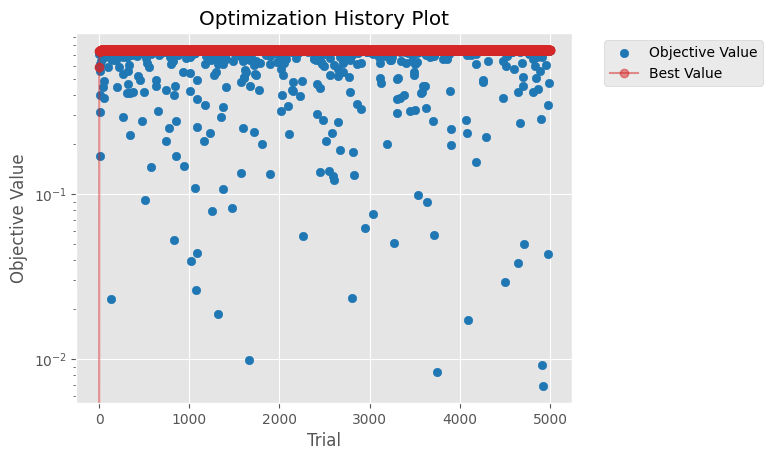

/var/folders/6m/8_2yd721373cx0m954405yd00000gn/T/ipykernel_79933/1910886387.py:8: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


KeyboardInterrupt: 

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.yscale('log') # use log scale for y axis
plt.show()

fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study, params=['q_var_pos', 'r_var_pos'])
plt.yscale('log') 
plt.show()
optuna.visualization.matplotlib.plot_slice(study, params=['q_var_size', 'r_var_size', 'p_cov_p0'])
plt.yscale('log') 
plt.show()


In [76]:
import json 

# save the best parameters
best_params = study.best_params
with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

---